In [1]:
# @title Install dependencies
# @markdown

#!pip install ipywidgets matplotlib torch torchvision tqdm hashlib requests 

In [2]:
# Install GNS and pyBPL
!pip install git+https://github.com/neuromatch/GNS-Modeling
!pip install git+https://github.com/neuromatch/pyBPL
!pip install numba

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/neuromatch/GNS-Modeling to /tmp/pip-req-build-5u9yovtx
  Running command git clone --filter=blob:none --quiet https://github.com/neuromatch/GNS-Modeling /tmp/pip-req-build-5u9yovtx
  Resolved https://github.com/neuromatch/GNS-Modeling to commit 5150c63a2d422ba2fb4b461570b6a8be8b10eea8
  Preparing metadata (setup.py) ... done
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeabl

In [3]:
# Standard libraries for file operations, operating system operations, web requests, and others
import hashlib
import logging
import os
import random
import requests
import shutil
import time
from importlib import reload
from zipfile import ZipFile
import zipfile
# Data handling and visualization libraries
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split

# Deep Learning libraries
import torch
from scipy.spatial.distance import cdist
from torchvision import transforms
from torchvision.transforms import ToPILImage

# IPython display & widgets for interactive controls in Jupyter notebooks
from IPython.display import clear_output, display
import ipywidgets as widgets

# pybpl and gns libraries for specific tasks
import gns
from gns import MODEL_SAVE_PATH
from gns.inference.parsing import get_topK_parses
from gns.omniglot.classification import ClassificationDataset
from gns.rendering import Renderer
from gns.type import TypeModel
from gns.utils.experiments import mkdir, time_string
import pybpl
from pybpl import splines, parameters
from pybpl.util import nested_map
from pybpl.util.stroke import dist_along_traj

# Additional utilities
from tqdm import tqdm

# Reload gns and its submodules if necessary
reload(gns)

<module 'gns' from '/home/samuele/.local/lib/python3.10/site-packages/gns/__init__.py'>

In [4]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle") 

In [5]:
# @title Plotting functions
# @markdown

def display_images(probe, options):
    # Open the probe image and the option images
    probe_image = Image.open(probe)
    option_images = [Image.open(img_path) for img_path in options]
    
    # Create a figure with the probe and the 3x3 grid for the options directly below
    fig = plt.figure(figsize=(15, 10))  # Adjust figure size as needed
    
    # Add the probe image to the top of the figure with a red border
    ax_probe = fig.add_subplot(4, 3, (1, 3))  # Span the probe across the top 3 columns
    ax_probe.imshow(probe_image)
    ax_probe.axis('off')
    rect = patches.Rectangle((0, 0), probe_image.width-1, probe_image.height-1, linewidth=2, edgecolor='r', facecolor='none')
    ax_probe.add_patch(rect)
    
    # Position the 3x3 grid of option images directly below the probe image
    for index, img in enumerate(option_images):
        row = (index // 3) + 1  # Calculate row in the 3x3 grid, starting directly below the probe
        col = (index % 3) + 1   # Calculate column in the 3x3 grid
        ax_option = fig.add_subplot(4, 3, row * 3 + col)  # Adjust grid position to directly follow the probe
        ax_option.imshow(img)
        ax_option.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
#@title Data retrieval for zip files
# @markdown

def handle_file_operations(fname, url, expected_md5, extract_to='data'):
    """Handles downloading, verifying, and extracting a file."""
    
    # Define helper functions for download, verify, and extract operations
    def download_file(url, filename):
        """Downloads file from the given URL and saves it locally."""
        try:
            r = requests.get(url, stream=True)
            r.raise_for_status()
            with open(filename, "wb") as fid:
                for chunk in r.iter_content(chunk_size=8192):
                    fid.write(chunk)
            print("Download successful.")
            return True
        except requests.RequestException as e:
            print(f"!!! Failed to download data: {e} !!!")
            return False
    
    def verify_file_md5(filename, expected_md5):
        """Verifies the file's MD5 checksum."""
        hash_md5 = hashlib.md5()
        with open(filename, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        if hash_md5.hexdigest() == expected_md5:
            print("MD5 checksum verified.")
            return True
        else:
            print("!!! Data download appears corrupted !!!")
            return False
    
    def extract_zip_file(filename, extract_to):
        """Extracts the ZIP file to the specified directory."""
        try:
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"File extracted successfully to {extract_to}")
        except zipfile.BadZipFile:
            print("!!! The ZIP file is corrupted or not a zip file !!!")
    
    # Main operation
    if not os.path.isfile(fname) or not verify_file_md5(fname, expected_md5):
        if download_file(url, fname) and verify_file_md5(fname, expected_md5):
            extract_zip_file(fname, extract_to)
    else:
        print(f"File '{fname}' already exists and is verified. Proceeding to extraction.")
        extract_zip_file(fname, extract_to)

# Example usage
file_info = [
    {"fname": "one-shot-classification.zip", "url": "https://osf.io/aw6eq/download", "expected_md5": "9376412e7fb74d64f045644b51e641a6"},
    {"fname": "omniglot-py.zip", "url": "https://osf.io/bazxp/download", "expected_md5": "f7a4011f5c25460c6d95ee1428e377ed"}
]

for file in file_info:
    handle_file_operations(**file)


MD5 checksum verified.
File 'one-shot-classification.zip' already exists and is verified. Proceeding to extraction.
File extracted successfully to data
MD5 checksum verified.
File 'omniglot-py.zip' already exists and is verified. Proceeding to extraction.
File extracted successfully to data


In [7]:
#@title Data retrieval
# @markdown

def download_file(url, filename):
    """
    Download a file from a given URL

    Parameters:
    url (str): URL to the file
    filename (str): Local filename to save the file
    """
    response = requests.get(url)
    response.raise_for_status()  # Raises an HTTPError if the HTTP request returned an unsuccessful status code.

    with open(filename, 'wb') as f:
        f.write(response.content)

def verify_checksum(filename, expected_checksum):
    """
    Verify the MD5 checksum of a file

    Parameters:
    filename (str): Path to the file
    expected_checksum (str): Expected MD5 checksum

    Returns:
    bool: True if the checksum matches, False otherwise
    """
    md5 = hashlib.md5()

    with open(filename, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b""):
            md5.update(chunk)

    return md5.hexdigest() == expected_checksum
    
def move_models_to_directory(model_files, destination_directory):
    """
    Move model files to a specified directory.

    Parameters:
    model_files (list of str): Filenames of the models to move.
    destination_directory (str): The destination directory where models will be moved.
    """
    for model_file in model_files:
        shutil.move(model_file, destination_directory + model_file)

def load_models(model_files, directory, map_location='cpu'):
    """
    Load multiple models from a specified directory.

    Parameters:
    model_files (list of str): Filenames of the models to load.
    directory (str): Directory from which to load the models.
    map_location (str): Device on which to load the models ('cpu' or 'cuda').

    Returns:
    dict: A dictionary of models, keyed by their filenames.
    """
    models = {}
    for model_file in model_files:
        full_path = directory + model_file
        models[model_file] = torch.load(full_path, map_location=map_location)
    return models

def verify_models_in_destination(model_files, destination_directory):
    """
    Verify the presence of model files in the specified directory.

    Parameters:
    model_files (list of str): Filenames of the models to verify.
    destination_directory (str): The directory where the models are supposed to be.

    Returns:
    bool: True if all models are found in the directory, False otherwise.
    """
    missing_files = []
    for model_file in model_files:
        # Construct the full path to where the model should be
        full_path = os.path.join(destination_directory, model_file)
        # Check if the model exists at the location
        if not os.path.exists(full_path):
            missing_files.append(model_file)

    if missing_files:
        print(f"Missing model files in destination: {missing_files}")
        return False
    else:
        print("All models are correctly located in the destination directory.")
        return True
        
# URLs and checksums for the models
models_info = {
    'location_model.pt': ('https://osf.io/zmd7y/download', 'dfd51cf7c3a277777ad941c4fcc23813'),
    'stroke_model.pt': ('https://osf.io/m6yc7/download', '511ea7bd12566245d5d11a85d5a0abb0'),
    'terminate_model.pt': ('https://osf.io/dsmhc/download', '2f3e26cfcf36ce9f9172c15d8b1079d1')
}

destination_directory = '/home/samuele/.local/lib/python3.10/site-packages/gns/'

for model_name, (url, checksum) in models_info.items():
    download_file(url, model_name)
    if verify_checksum(model_name, checksum):
        print(f"Successfully verified {model_name}")
    else:
        print(f"Checksum does not match for {model_name}. Download might be corrupted.")
        continue  

# Define model filenames
model_files = list(models_info.keys())

# Move models to the specified directory
move_models_to_directory(model_files, destination_directory)

# Verify the presence of the models in the destination directory
if verify_models_in_destination(model_files, destination_directory):
    print("Verification successful: All models are in the correct directory.")
else:
    print("Verification failed: Some models are missing from the destination directory.")

# Load the models from the new location
models = load_models(model_files, destination_directory, map_location='cpu')

Successfully verified location_model.pt
Successfully verified stroke_model.pt
Successfully verified terminate_model.pt
All models are correctly located in the destination directory.
Verification successful: All models are in the correct directory.


In [8]:
#@title Helper functions
# @markdown

def select_random_images_within_alphabet(base_path, alphabet_path, exclude_character_path, num_images=8):
    chosen_images = []
    all_characters = [char for char in os.listdir(alphabet_path) if os.path.isdir(os.path.join(alphabet_path, char)) and os.path.join(alphabet_path, char) != exclude_character_path]
    while len(chosen_images) < num_images:
        if not all_characters:
            break
        character = random.choice(all_characters)
        character_path = os.path.join(alphabet_path, character)
        all_images = [img for img in os.listdir(character_path) if img.endswith('.png')]
        if not all_images:
            continue
        image_file = random.choice(all_images)
        image_path = os.path.join(character_path, image_file)
        chosen_images.append(image_path)
    return chosen_images

def run_trial(base_path, num_trials):
    for _ in range(num_trials):
        languages = [lang for lang in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, lang))]
        selected_language = random.choice(languages)
        language_path = os.path.join(base_path, selected_language)
        characters = [char for char in os.listdir(language_path) if os.path.isdir(os.path.join(language_path, char))]
        selected_character = random.choice(characters)
        character_path = os.path.join(language_path, selected_character)
        images = [img for img in os.listdir(character_path) if img.endswith('.png')]
        probe_image_path, correct_answer_image_path = random.sample(images, 2)
        probe_image_path = os.path.join(character_path, probe_image_path)
        correct_answer_image_path = os.path.join(character_path, correct_answer_image_path)
        wrong_answers = select_random_images_within_alphabet(base_path, language_path, character_path, num_images=8)
        options = wrong_answers
        options.insert(random.randint(0, len(options)), correct_answer_image_path)
        display_images(probe_image_path, options)

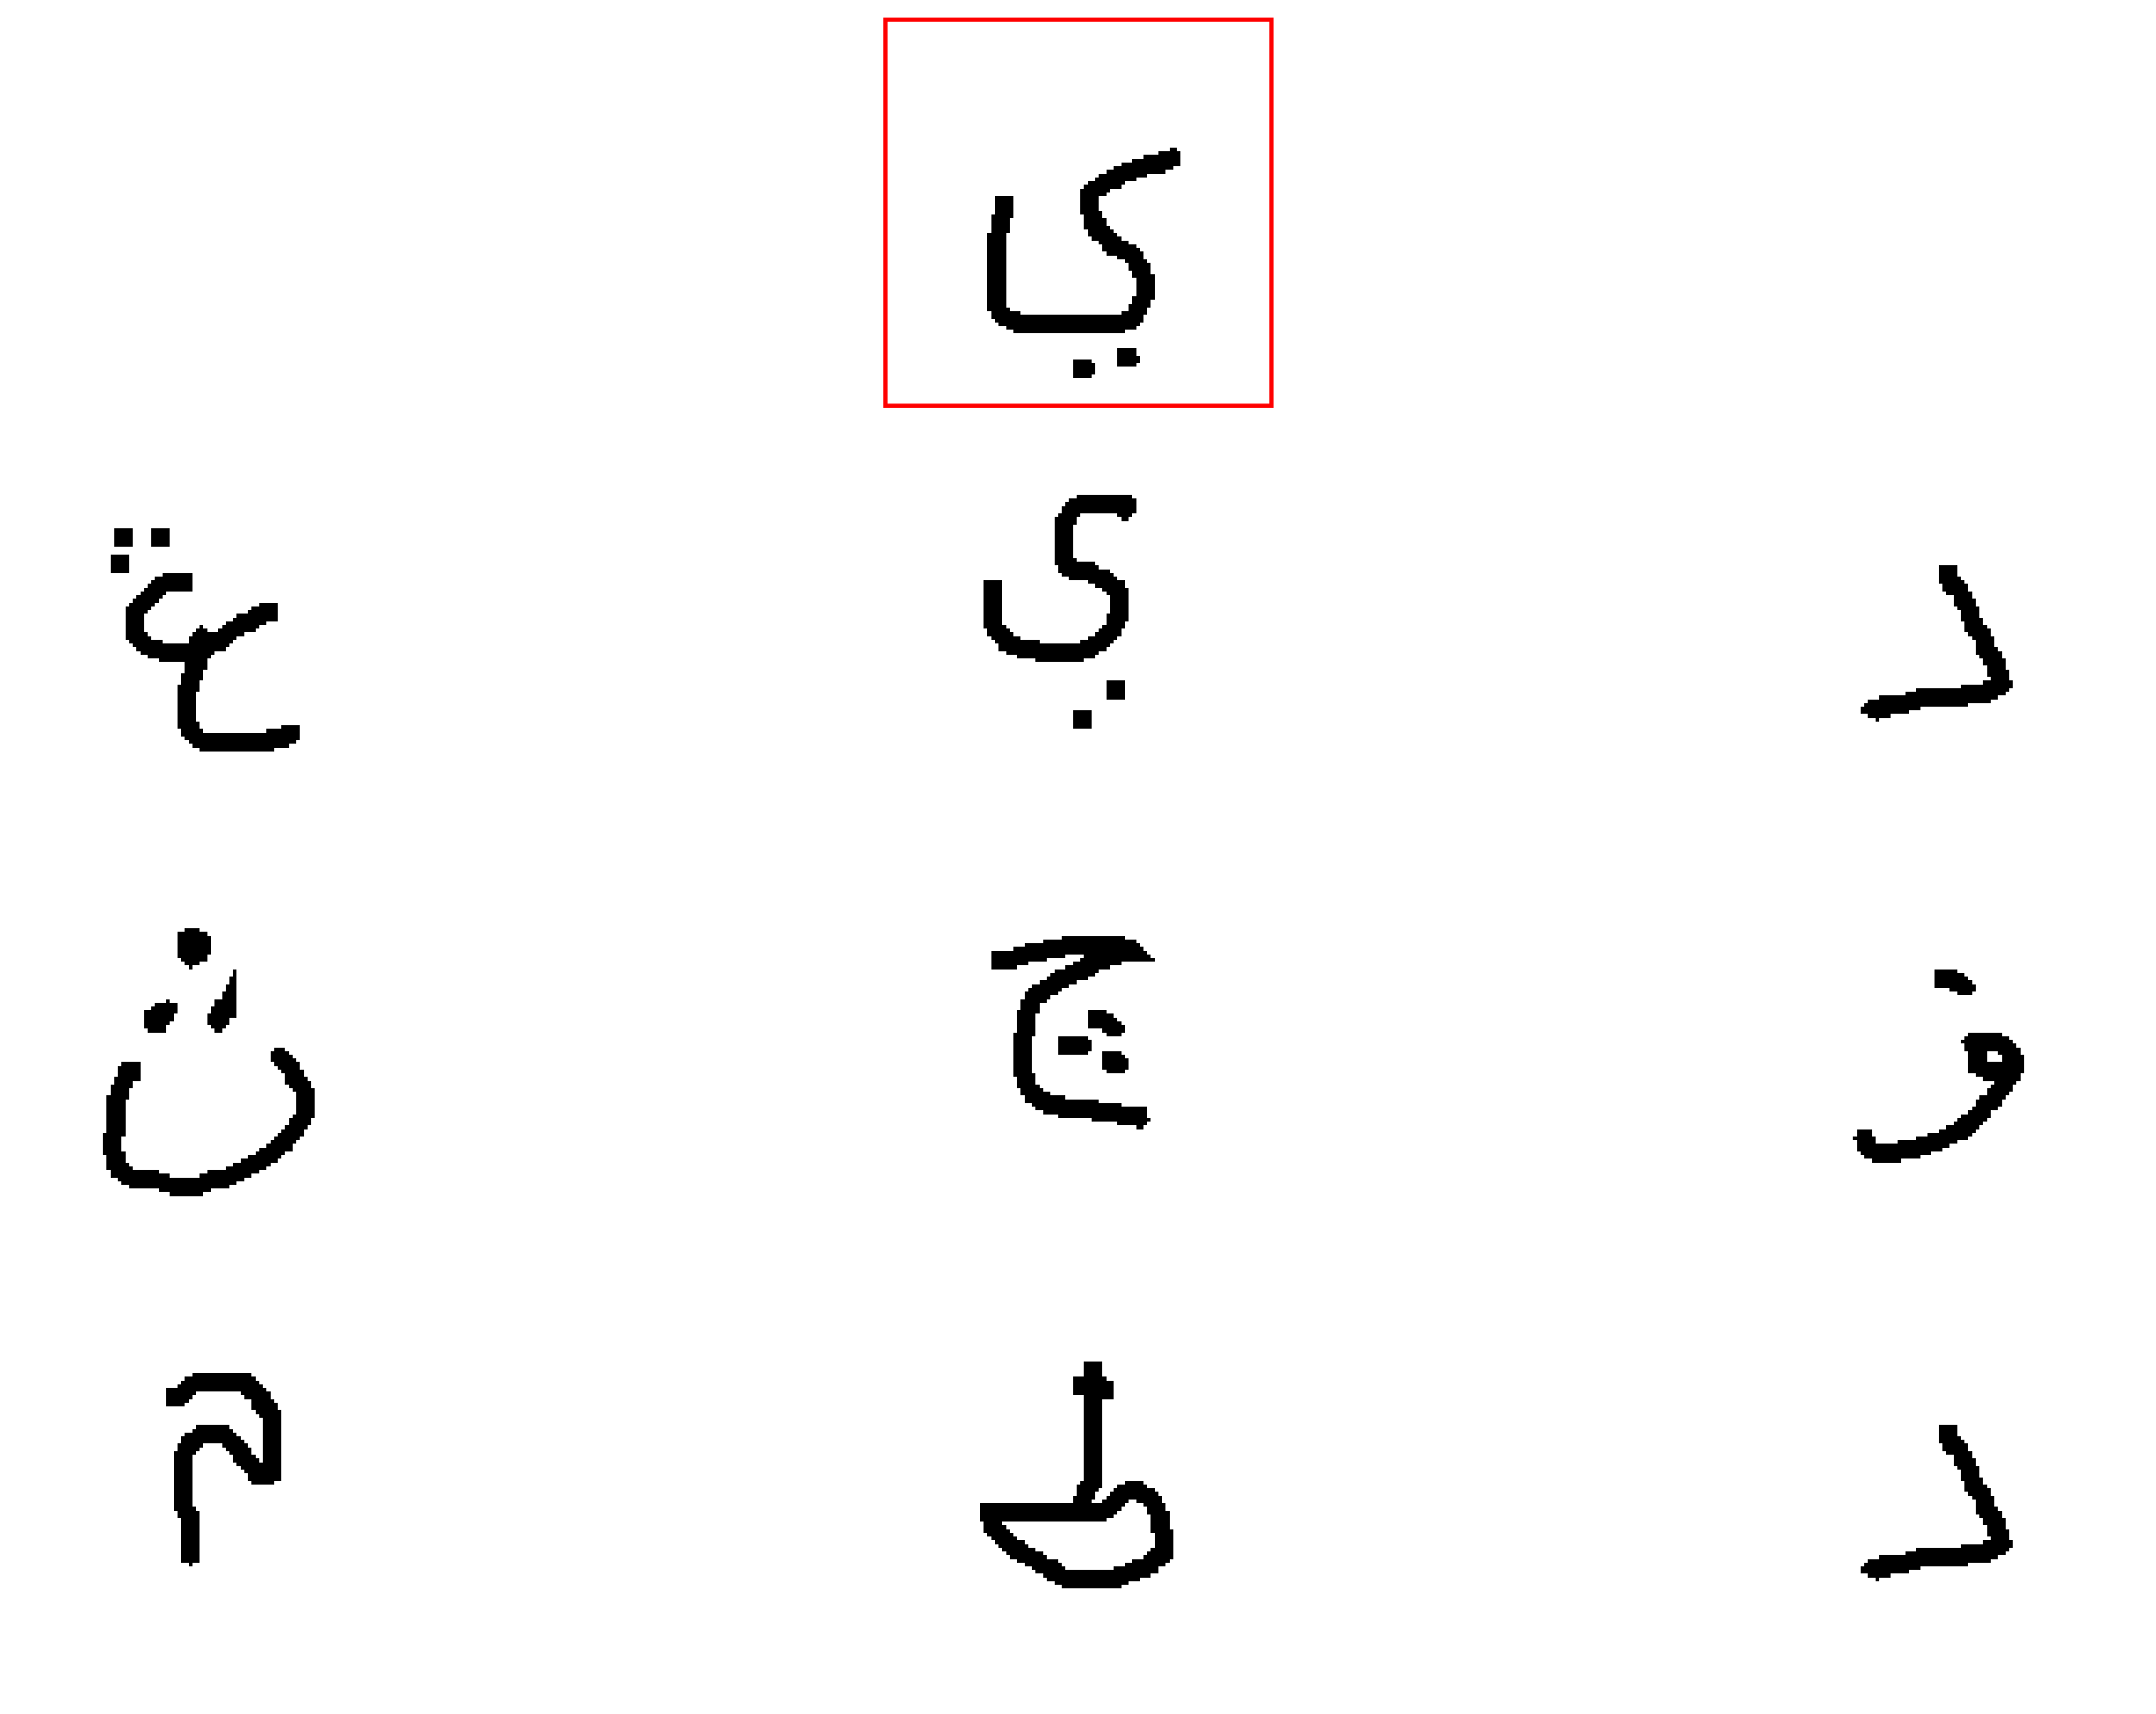

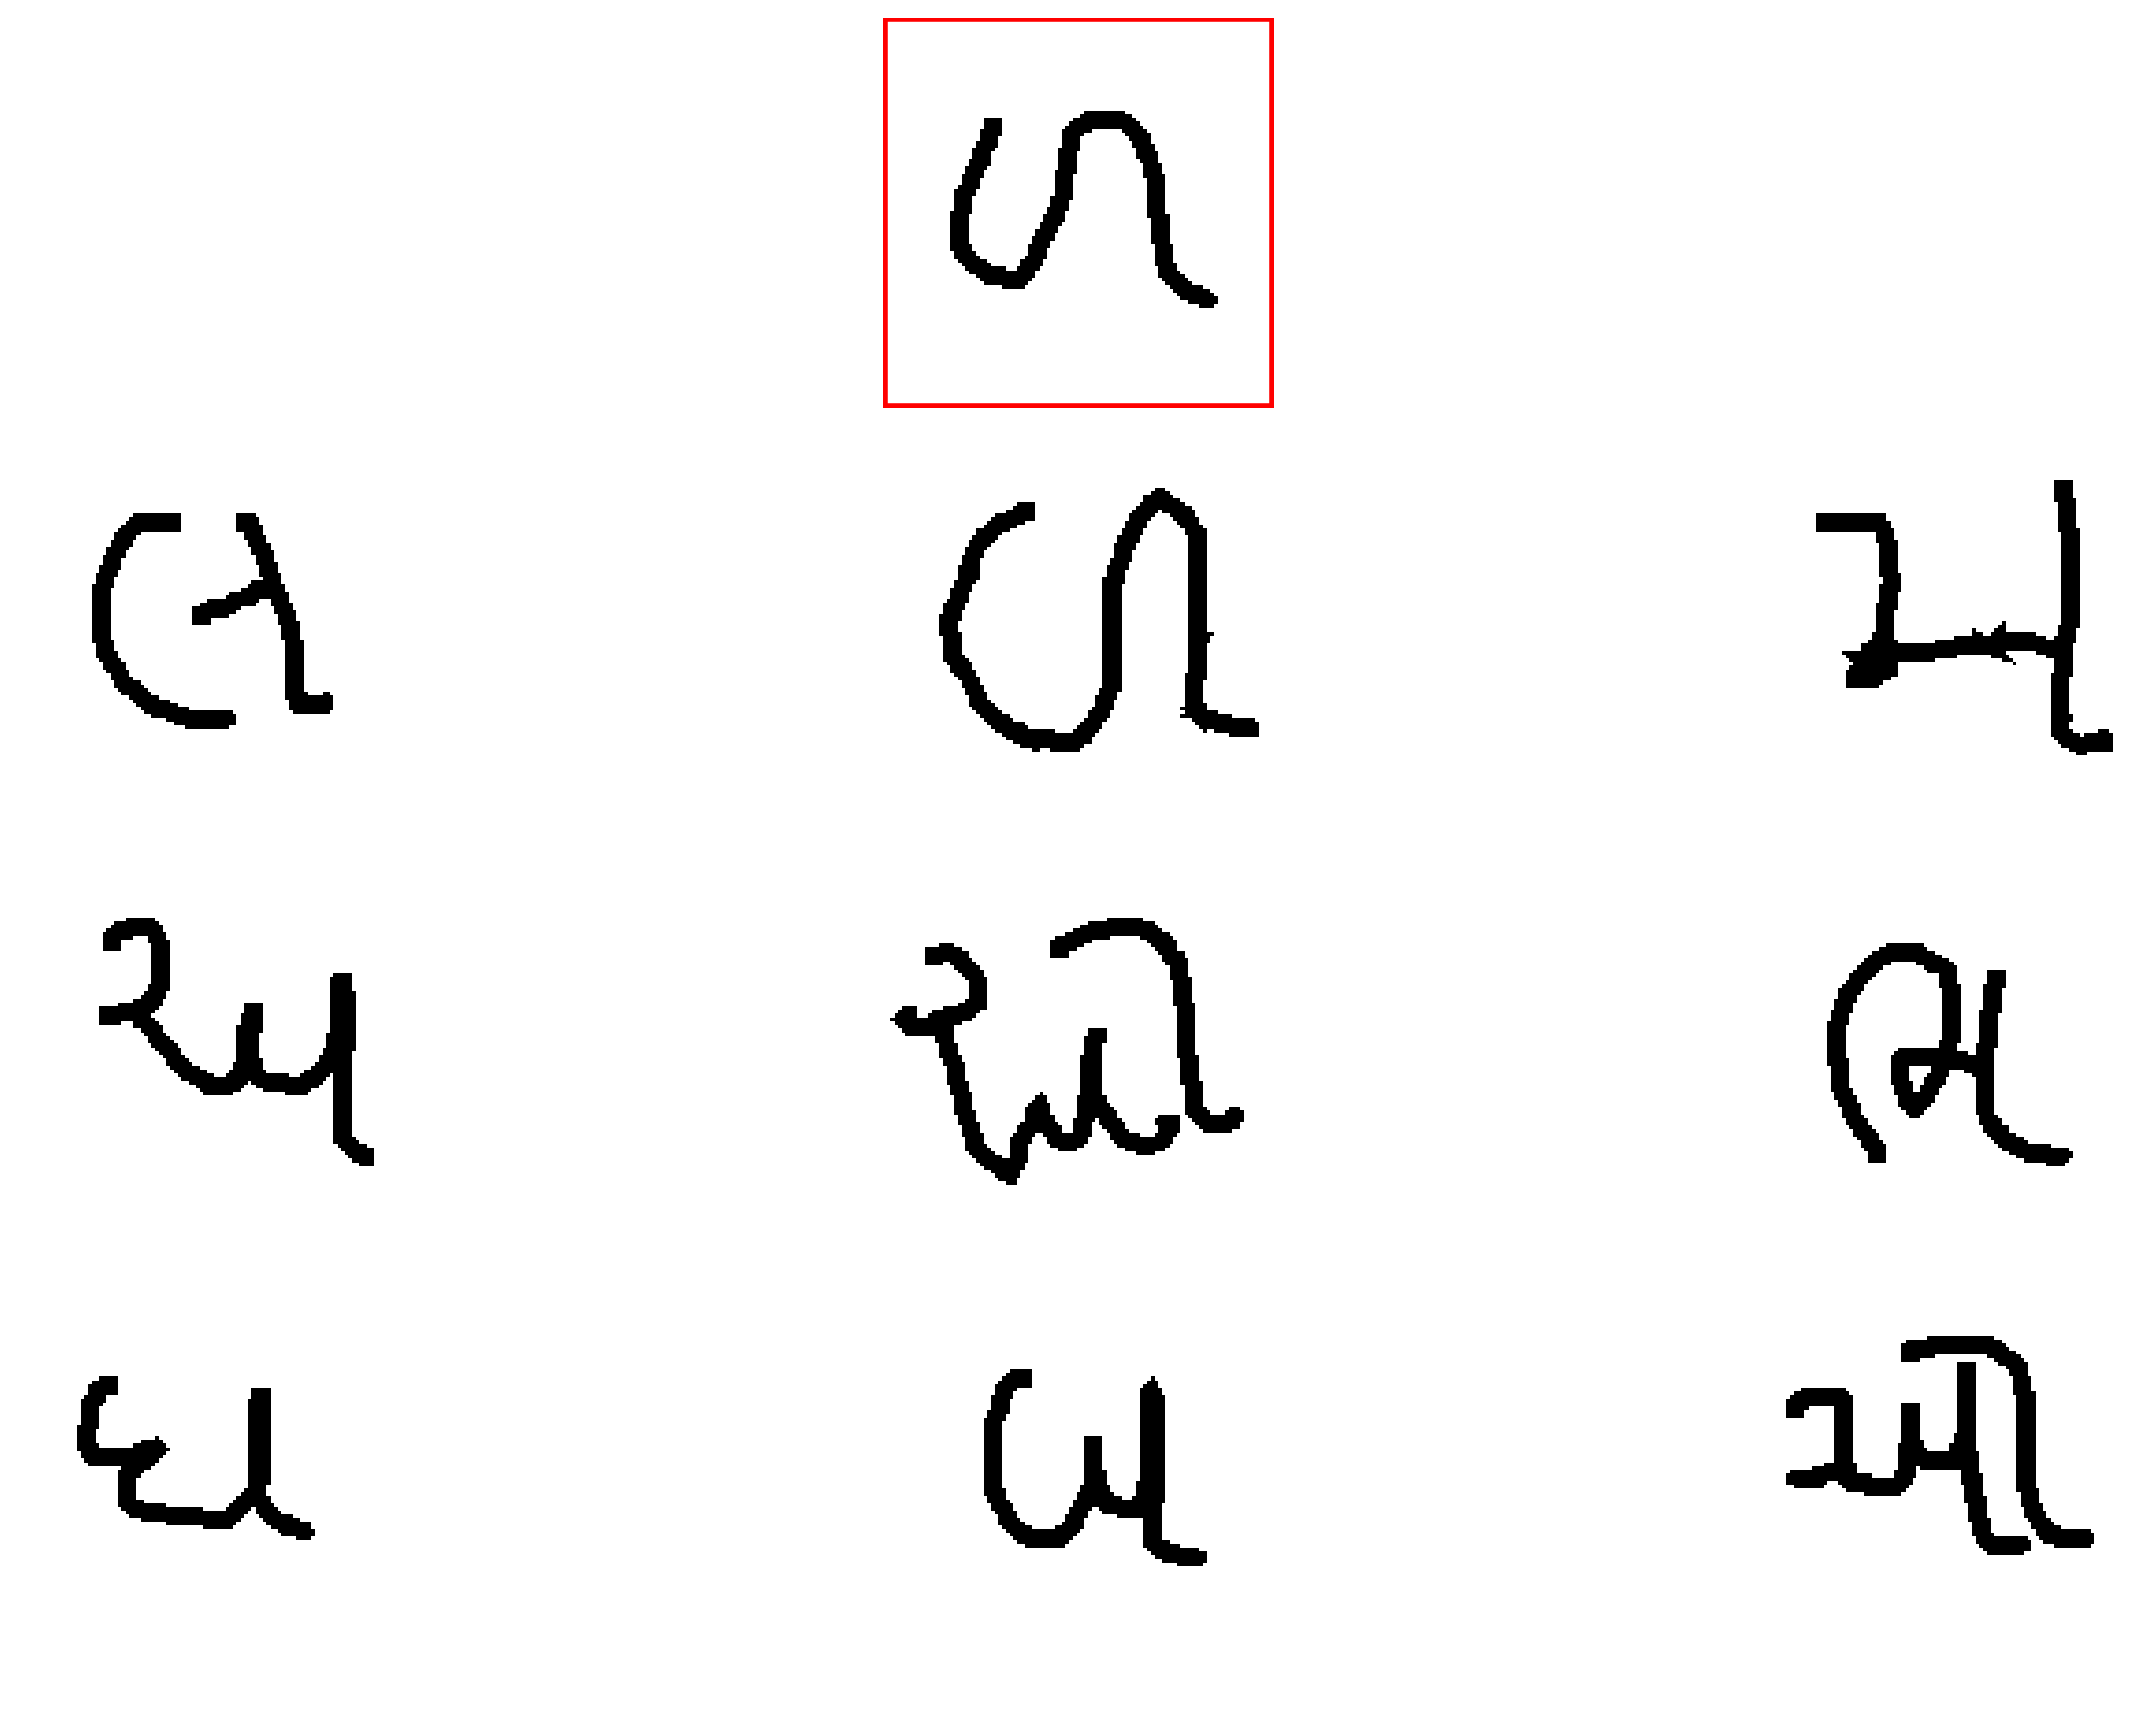

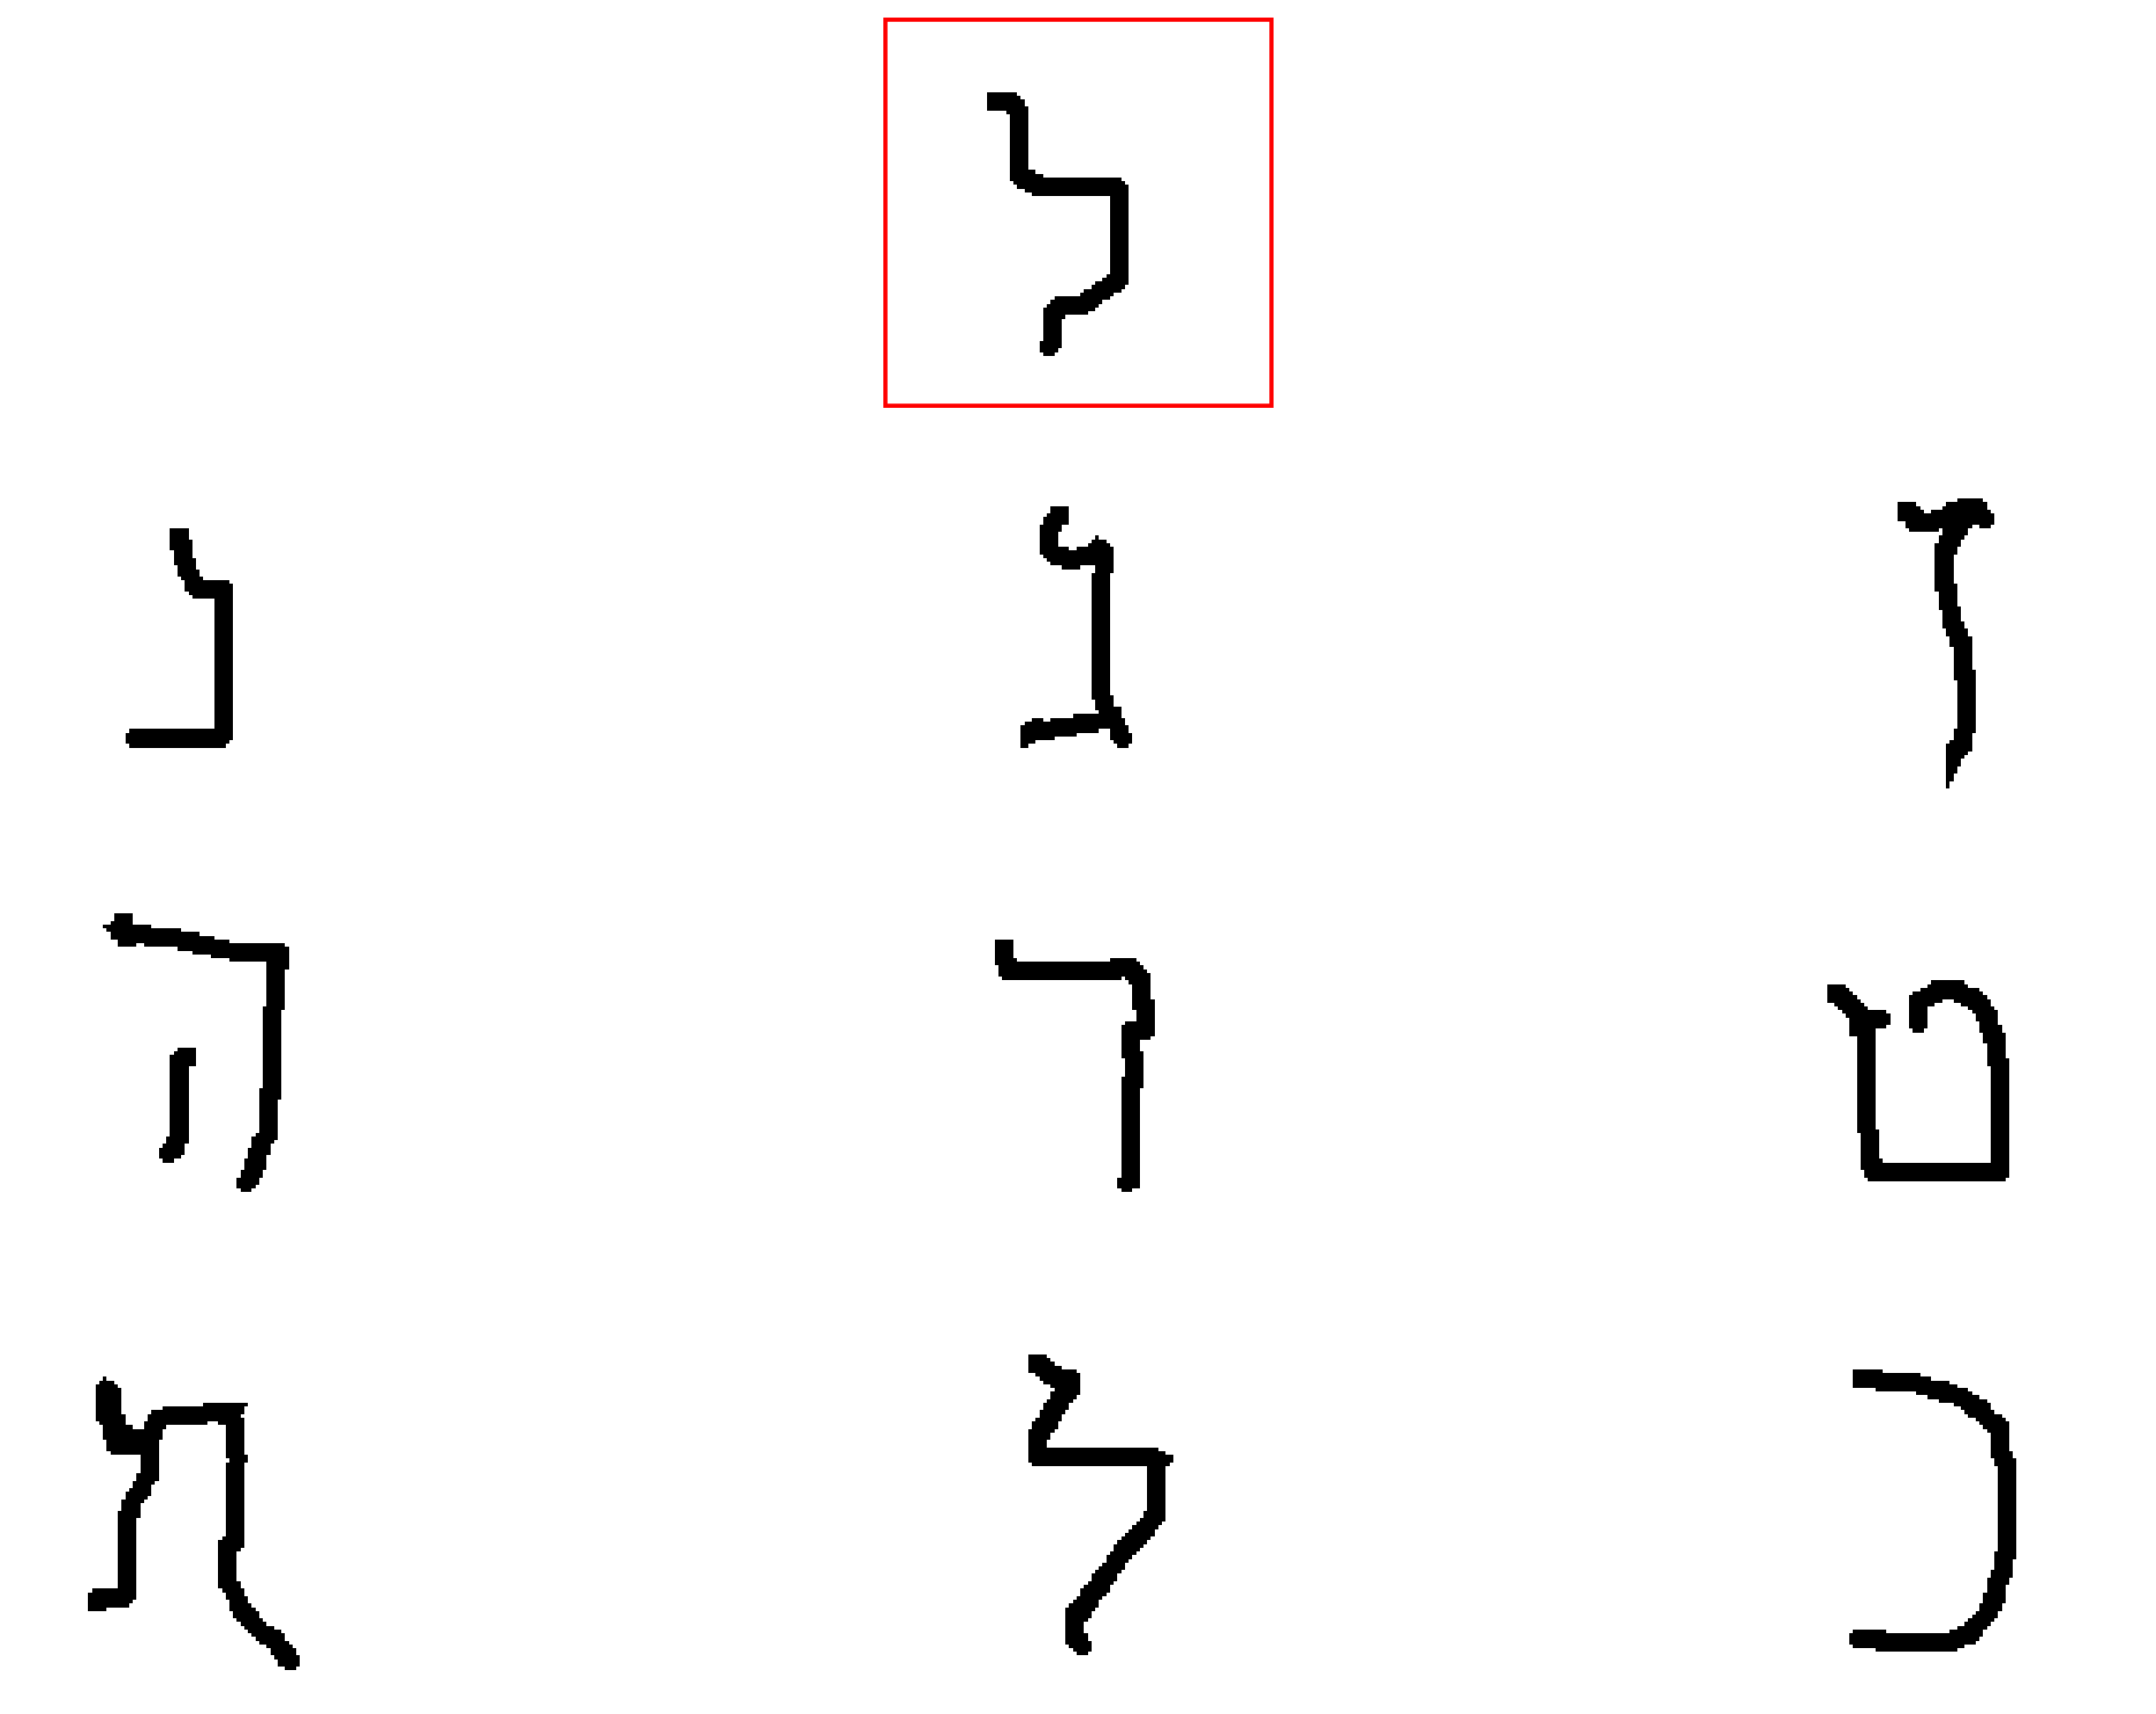

In [9]:
# Paths
base_path = "data/omniglot-py/images_background"

# Running the trial
run_trial(base_path, num_trials=3)

In [10]:
# Reflection activity: How do you think you, as a human, are performing a task like Omniglot?
# One-shot learning
# Segmentation
# Conditioned generation
# Unconditioned generation


In [11]:
@torch.no_grad()
def model_score_fn(model, parses):
    drawings = nested_map(lambda x: splines.get_stk_from_bspline(x), parses)
    if torch.cuda.is_available():
        drawings = nested_map(lambda x: x.cuda(), drawings)
        parses = nested_map(lambda x: x.cuda(), parses)
    losses = model.losses_fn(parses, drawings, filter_small=False, denormalize=True)
    return -losses.cpu()

def collect_img_results(img_id, parses, log_probs, reverse):
    """Collects parses and log probabilities without saving to disk."""
    appendix = 'test' if reverse else 'train'
    data = {
        'img_id': img_id,
        'appendix': appendix,
        'parses': parses,
        'log_probs': log_probs,
    }
    return data

def get_base_parses_in_memory(run_id, trials_per=800, reverse=False, dry_run=False):
    print('run_id: %i' % run_id)
    print('Loading model...')
    # Correctly identify the base directory of the `gns` package
    gns_base_dir = os.path.dirname(gns.__file__)
    
    # Specify the model save directory within the `gns` package
    model_save_path = os.path.join(gns_base_dir, 'model_saves')
    
    # Initialize TypeModel with the correct model save path
    type_model = TypeModel(save_dir=model_save_path).eval()

    if torch.cuda.is_available():
        type_model = type_model.cuda()
    score_fn = lambda parses: model_score_fn(type_model, parses)

    # Use the dynamically determined path
    osc_path = os.path.join(os.getcwd(), 'data/one-shot-classification')
    print('Loading classification dataset...')
    dataset = ClassificationDataset(osc_folder=osc_path)
    run = dataset.runs[run_id]
    imgs = run.test_imgs if reverse else run.train_imgs

    collected_data = []  # In-memory storage for parses and log_probs

    print('Collecting top-K parses for each train image...')
    nimg = len(imgs)
    for i in range(nimg):
        start_time = time.time()
        parses, log_probs = get_topK_parses(
            imgs[i], k=5, score_fn=score_fn, configs_per=1,
            trials_per=trials_per)
        total_time = time.time() - start_time
        print(f'image {i+1}/{nimg} took {time_string(total_time)}')
        if dry_run:
            continue
        img_results = collect_img_results(i, parses, log_probs, reverse)
        collected_data.append(img_results)

    return collected_data

# Example usage
run_id = 10
trials_per = 800
reverse = False
dry_run = False

# Call the modified function
collected_data = get_base_parses_in_memory(run_id=run_id, trials_per=trials_per, reverse=reverse, dry_run=dry_run)

run_id: 10
Loading model...


/home/samuele/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading classification dataset...


/home/samuele/.local/lib/python3.10/site-packages/pybpl/bottomup/generate_random_parses.py:9: UserWarning: using untested python implementation of 'generate_random_walks'
  warnings.warn("using untested python implementation of "


image 1/20 took 0:00:05


/home/samuele/.local/lib/python3.10/site-packages/pybpl/bottomup/generate_random_parses.py:9: UserWarning: using untested python implementation of 'generate_random_walks'
  warnings.warn("using untested python implementation of "


image 2/20 took 0:00:07
image 3/20 took 0:00:01
image 4/20 took 0:00:03
image 5/20 took 0:00:02
image 6/20 took 0:00:24
image 7/20 took 0:00:02
image 8/20 took 0:00:05
image 9/20 took 0:00:02
image 10/20 took 0:00:32
image 11/20 took 0:00:30
image 12/20 took 0:00:02
image 13/20 took 0:00:02
image 14/20 took 0:00:02
image 15/20 took 0:00:32
image 16/20 took 0:00:02
image 17/20 took 0:00:07
image 18/20 took 0:00:19
image 19/20 took 0:00:02
image 20/20 took 0:00:07


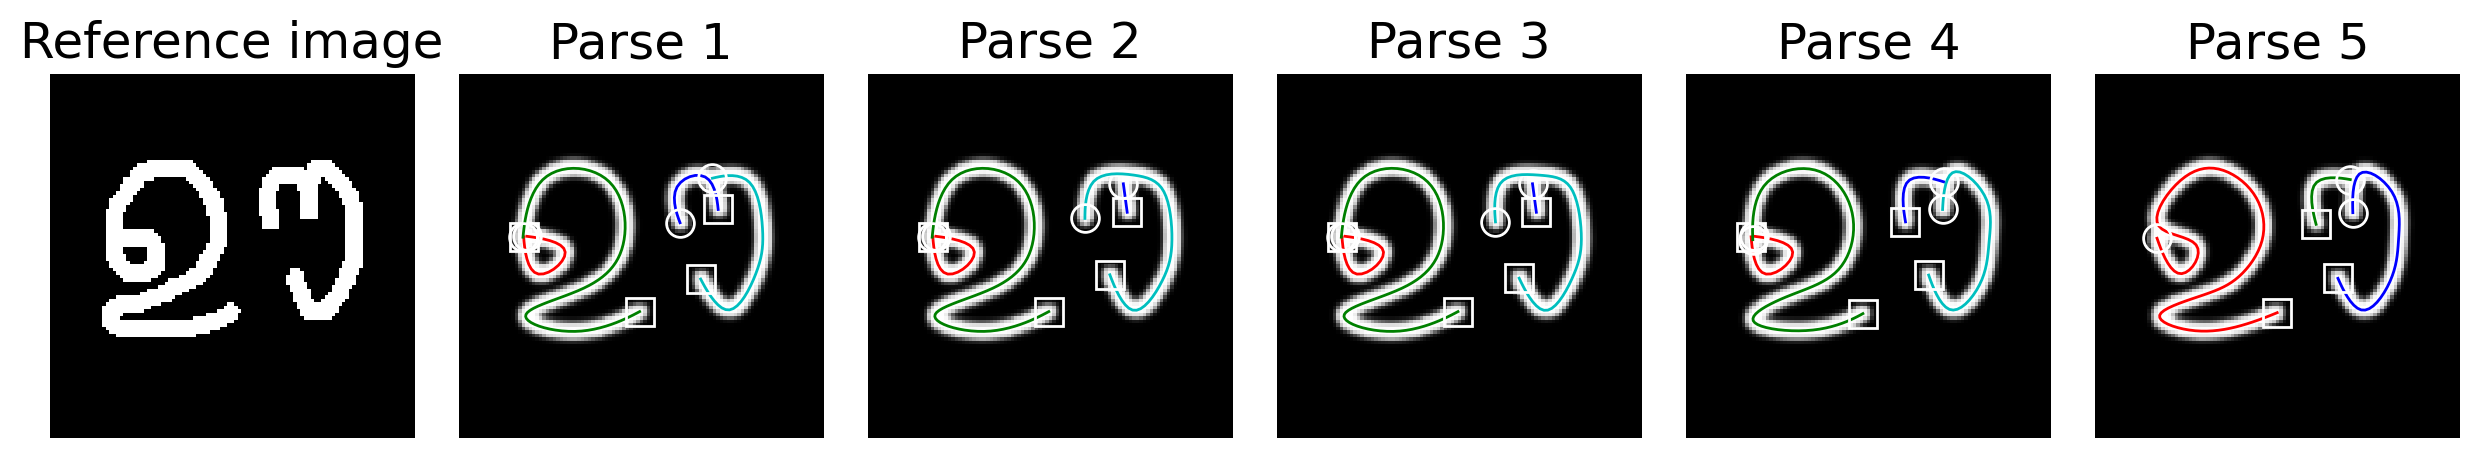

In [15]:
# Use retina mode for matplotlib
%config InlineBackend.figure_format = 'retina'

# Function to visualize parses
def visualize_parses(collected_data, item, run):
    # Load the classification labels to map test images to their corresponding training images
    with open(f'./data/one-shot-classification/all_runs/run{run+1:02}/class_labels.txt') as f:
        data = f.readlines()

    test_to_train = {}
    for line in data:
        left, right = line.split(' ')
        test_to_train[left.split('/')[-1]] = right.split('/')[-1].strip()

    plt.figure(figsize=(12.5, 2.5))
    train_im = test_to_train[f'item{item:02}.png']

    # Reference image visualization
    plt.subplot(1, 6, 1)
    plt.imshow(1 - plt.imread(f'./data/one-shot-classification/all_runs/run{run+1:02}/training/{train_im}'), cmap='gray')
    plt.title('Reference image')
    plt.axis('off')

    # Load parses from the collected data
    for img_data in collected_data:
        if img_data['img_id'] == item - 1:
            parses = img_data['parses']
            break

    r = Renderer()
    # Visualization of parses
    for i, parse in enumerate(parses):
        drawings = [splines.get_stk_from_bspline(x) for x in parse]
        plt.subplot(1, 6, i+2)
        plt.imshow(r(drawings), cmap='gray')
        plt.axis('off')
        plt.title(f'Parse {i+1}')

        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        for i, d in enumerate(drawings):
            plt.plot(d[:, 0], -d[:, 1], colors[i], linewidth=1)
            plt.plot(d[0, 0], -d[0, 1], 'w.', markersize=20, fillstyle='none')
            plt.plot(d[-1, 0], -d[-1, 1], 'ws', markersize=10, fillstyle='none')

# Example of visualizing parses for a specific item and run
visualize_parses(collected_data, item=6, run=10)